In [18]:
import time
import pandas as pd
import numpy as np
from copy import copy, deepcopy

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score

from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

import seaborn as sns

from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

# Preprocessing
### Get feature and label columns
Since this is a multi-label classification problem there are multiple label columns instead of one. Only a few of the most popular genres are kept, because less popular labels give highly imbalanced training data. A new `other` label is created for bands whose genre is not included in genre list. The drawback to this is that some genres that may correlate highly with a popular genre (e.g. speed with thrash) may be lumped into the `other` label.

In [2]:
df_full = pd.read_csv('data.csv', index_col=0)
# label_cols = [c for c in df_full.columns if 'genre_' in c]
label_cols = ['genre_' + g for g in ['black', 'death', 'doom', 'folk', 'heavy', 'power', 'progressive', 'thrash']]
df_full['genre_other'] = (df_full[label_cols].sum(axis=1) == 0).astype(int)
label_cols.append('genre_other')
feature_cols = [c for c in df_full.columns if 'genre_' not in c]
genres = [c.replace('genre_', '') for c in label_cols]
print('genres: ', genres)

genres:  ['black', 'death', 'doom', 'folk', 'heavy', 'power', 'progressive', 'thrash', 'other']


### Reject low-correlation features
This is done by generating a correlation matrix between features and labels. The `corr` matrix describes how correlated each feature (word) is with each label (genre). For each label, only features whose absolute label correlation exceeds 3 times the mean absolute label correlation. The final feature list is the set of all features kept.

In [3]:
words = set()
for label_col in label_cols:
    corr = df_full[feature_cols].apply(lambda x: x.corr(df_full[label_col]))
#     corr = corr[corr.abs().argsort()][len(corr) // 2:].sort_values()
    corr_words = corr.index[corr.abs() > 3 * corr.abs().mean()]
    words.update(set(corr_words))
feature_cols_r = sorted(words)

In [4]:
len(feature_cols_r), len(feature_cols)

(11505, 35258)

# Models
### Stacked model
* Trains one or more base models on binary classification of a label
* Trains a final model on the base model prediction probabilities
* The final model essentiall tunes the threshold for converting prediction probabilities to predictions

In [5]:
class StackedModel:
    def __init__(self, base_models, final_model):
        self.base_models = base_models
        self.final_model = final_model

    @property
    def model_names(self):
        return [type(m).__name__ for m in self.base_models]

    def fit(self, X, y, **kwargs):
        n_splits = kwargs.get('n_splits', 5)
        random_state = kwargs.get('random_state', 0)
        folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        S = np.zeros((len(y), len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_idx, val_idx in folds.split(X, y):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]
                if self.model_names[i] == 'Sequential':
                    model.fit(X_train, y_train, validation_data=(X_val, y_val), **model_args)
                else:
                    model.fit(X_train, y_train)
                y_prob = model.predict_proba(X_val)
                S[val_idx, i] = y_prob[:, y_prob.shape[1] - 1]
        S = S.mean(axis=1).reshape(-1, 1)
        self.final_model.fit(S, y)

    def predict(self, X):
        S = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            y_prob = model.predict_proba(X)
            S[:, i] = y_prob[:, y_prob.shape[1] - 1]
        S = S.mean(axis=1).reshape(-1, 1)
        y = self.final_model.predict(S)
        return y

    def predict_proba(self, X):
        S = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            y_prob = model.predict_proba(X)
            S[:, i] = y_prob[:, y_prob.shape[1] - 1]
        S = S.mean(axis=1).reshape(-1, 1)
        y = self.final_model.predict_proba(S)
        return y

### Binary relevance model
* Trains a binary (one-vs-all) classifier on each label in ``labels``
* Normalizes prediction probabilities across labels so that $P(\textrm{any label}|\textrm{data}) = 1$
* Gives positive results when probability is higher than random guessing, i.e. $P(\textrm{label}|\textrm{data}) N_{labels} > 1$

In [6]:
class BinaryRelevance:
    def __init__(self, estimator, features, labels, oversampler=None):
        self.estimator = estimator
        self.features = features
        self.labels = labels
        self.estimators_ = {}
        self.oversampler = oversampler

    def fit(self, df_train, **kwargs):
        X_train = df_train[self.features].values
        models = {}
        for label in self.labels:
            print('training binary classifier for label: ' + label)
            y_train = df_train[label].values
            if self.oversampler:
                X_train_resample, y_train_resample = self.oversampler.fit_resample(X_train, y_train)
            else:
                X_train_resample, y_train_resample = X_train, y_train
            model = deepcopy(self.estimator)
            model.fit(X_train_resample, y_train_resample, **kwargs)
            models[label] = model
        self.estimators_ = models

    def predict(self, df_test):
        X_test = df_test[self.features].values
        df_pred = pd.DataFrame(index=df_test.index, columns=self.labels)
        df_prob = pd.DataFrame(index=df_test.index, columns=self.labels)
        for label in self.labels:
            model = self.estimators_[label]
            y_prob = model.predict_proba(X_test)
            df_prob[label] = y_prob[:, y_prob.shape[1] - 1]
#         df_prob = df_prob.div(df_prob.sum(axis=1), axis=0)
#         thresh = 1. / len(self.labels)
        thresh = 0.5
        for i, row in df_prob.iterrows():
            df_pred.loc[i] = (row >= thresh).astype(int)
        return df_pred, df_prob

### Base models

* Keras neural network
* Random forest classifier with parameters determined via grid search in `tuned-models.ipynb`
* Gaussian Naive Bayes classifier
* Logistic regression to be used as the stacked model aggregator

In [7]:
def keras_model(input_dim=None, n_nodes=(10,)):
    model = Sequential()
    model.add(layers.Dense(n_nodes[0], input_dim=input_dim, activation='relu'))
    for n in n_nodes[1:]:
        model.add(layers.Dense(n, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [8]:
nn_model = KerasClassifier(keras_model, input_dim=len(feature_cols_r), n_nodes=(10,), batch_size=4, epochs=16, verbose=False)

rf_params = {'bootstrap': True, 'max_depth': 30, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
rf_model = RandomForestClassifier(n_jobs=-1, random_state=0, **rf_params)

nb_model = GaussianNB()

lr_model = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=0)

### Neural network only (no stacking)

In [16]:
df_features = df_full[feature_cols_r]
df_norm = pd.concat((df_features.div(df_features.sum(axis=1), axis=0), df_full[label_cols]), axis=1)
df_train, df_test = train_test_split(df_norm, test_size=0.2, random_state=0)
br = BinaryRelevance(
    KerasClassifier(keras_model, input_dim=len(feature_cols_r), n_nodes=(10,), batch_size=4, epochs=16, verbose=False),
    feature_cols_r,
    label_cols,
    oversampler=RandomOverSampler(random_state=0)
)
t0 = time.time()
br.fit(df_train)
print("training took {} seconds".format(time.time() - t0))
df_pred, df_prob = br.predict(df_test)
df_true = df_test[label_cols]
scores = []
for label in label_cols:
    score = balanced_accuracy_score(df_true[label], df_pred[label])
    print("{}: {:.4f}".format(label.replace('genre_', ''), score))
    scores.append(score)
print("average: {:.4f}".format(np.mean(scores)))

training binary classifier for label: genre_black
training binary classifier for label: genre_death
training binary classifier for label: genre_doom
training binary classifier for label: genre_folk
training binary classifier for label: genre_heavy
training binary classifier for label: genre_power
training binary classifier for label: genre_progressive
training binary classifier for label: genre_thrash
training binary classifier for label: genre_other
black: 0.7934
death: 0.8279
doom: 0.7082
folk: 0.7431
heavy: 0.8875
power: 0.8976
progressive: 0.7713
thrash: 0.8388
other: 0.6598
average: 0.7920


In [21]:
df_features = df_full[feature_cols_r]
df_norm = pd.concat((df_features.div(df_features.sum(axis=1), axis=0), df_full[label_cols]), axis=1)
df_train, df_test = train_test_split(df_norm, test_size=0.2, random_state=0)
br = BinaryRelevance(
    KerasClassifier(keras_model, input_dim=len(feature_cols_r), n_nodes=(20, 10), batch_size=4, epochs=16, verbose=False),
    feature_cols_r,
    label_cols,
    oversampler=RandomOverSampler(random_state=0)
)
t0 = time.time()
br.fit(df_train)
print("training took {:.0f} seconds".format(time.time() - t0))
df_pred, df_prob = br.predict(df_test)
df_true = df_test[label_cols]
scores = []
for label in label_cols:
    score = balanced_accuracy_score(df_true[label], df_pred[label])
    print("{}: {:.4f}".format(label.replace('genre_', ''), score))
    scores.append(score)
print("average: {:.4f}".format(np.mean(scores)))

training binary classifier for label: genre_black
training binary classifier for label: genre_death
training binary classifier for label: genre_doom
training binary classifier for label: genre_folk
training binary classifier for label: genre_heavy
training binary classifier for label: genre_power
training binary classifier for label: genre_progressive
training binary classifier for label: genre_thrash
training binary classifier for label: genre_other
training took 144 seconds
black: 0.8064
death: 0.7802
doom: 0.6138
folk: 0.5761
heavy: 0.7552
power: 0.7851
progressive: 0.5673
thrash: 0.8139
other: 0.6138
average: 0.7013


In [21]:
plot_history(br.estimators_['genre_black'].history, val=False)

NameError: name 'plot_history' is not defined

### Stacked model

In [ ]:
stacked_model = StackedModel(
    base_models=[
        nn_model,
#         rf_model,
#         lr_model
#         nb_model
    ],
    final_model=lr_model
)

In [42]:
df_features = df_full[feature_cols_r]
df_norm = pd.concat((df_features.div(df_features.sum(axis=1), axis=0), df_full[label_cols]), axis=1)
df_train, df_test = train_test_split(df_norm, test_size=0.2, random_state=0)
br = BinaryRelevance(
    StackedModel(
        base_models=[
            KerasClassifier(keras_model, input_dim=len(feature_cols_r), n_nodes=(10,), batch_size=4, epochs=16, verbose=False),
        ],
        final_model=lr_model
    ),
    feature_cols_r,
    label_cols,
    oversampler=RandomOverSampler(random_state=0)
)
br.fit(df_train)
df_pred, df_prob = br.predict(df_test)
df_true = df_test[label_cols]
scores = []
for label in label_cols:
    score = balanced_accuracy_score(df_true[label], df_pred[label])
    print("{}: {:.4f}".format(label.replace('genre_', ''), score))
    scores.append(scores)
print("average: {:.4f}".format(np.mean(scores)))

training binary classifier for label: genre_black
training binary classifier for label: genre_death
training binary classifier for label: genre_doom
training binary classifier for label: genre_folk
training binary classifier for label: genre_heavy
training binary classifier for label: genre_power
training binary classifier for label: genre_progressive
training binary classifier for label: genre_thrash
training binary classifier for label: genre_other
black: 0.7993
death: 0.7854
doom: 0.6810
folk: 0.7542
heavy: 0.8723
power: 0.7354
progressive: 0.6894
thrash: 0.8347
other: 0.6598
average: nan


/home/philippe/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/philippe/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [43]:
df_features = df_full[feature_cols_r]
df_norm = pd.concat((df_features.div(df_features.sum(axis=1), axis=0), df_full[label_cols]), axis=1)
df_train, df_test = train_test_split(df_norm, test_size=0.2, random_state=0)
br = BinaryRelevance(
    StackedModel(
        base_models=[
            KerasClassifier(keras_model, input_dim=len(feature_cols_r), n_nodes=(40,), batch_size=4, epochs=16, verbose=False),
        ],
        final_model=lr_model
    ),
    feature_cols_r,
    label_cols,
    oversampler=RandomOverSampler(random_state=0)
)
br.fit(df_train)
df_pred, df_prob = br.predict(df_test)
df_true = df_test[label_cols]
scores = []
for label in label_cols:
    score = balanced_accuracy_score(df_true[label], df_pred[label])
    print("{}: {:.4f}".format(label.replace('genre_', ''), score))
    scores.append(scores)
print("average: {:.4f}".format(np.mean(scores)))

training binary classifier for label: genre_black
training binary classifier for label: genre_death
training binary classifier for label: genre_doom
training binary classifier for label: genre_folk
training binary classifier for label: genre_heavy
training binary classifier for label: genre_power
training binary classifier for label: genre_progressive
training binary classifier for label: genre_thrash
training binary classifier for label: genre_other
black: 0.8052
death: 0.8123
doom: 0.6316
folk: 0.7542
heavy: 0.8399
power: 0.8161
progressive: 0.5373
thrash: 0.7927
other: 0.6101
average: nan


/home/philippe/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/philippe/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
df_features = df_full[feature_cols_r]
df_norm = pd.concat((df_features.div(df_features.sum(axis=1), axis=0), df_full[label_cols]), axis=1)
df_train, df_test = train_test_split(df_norm, test_size=0.2, random_state=0)
br = BinaryRelevance(
    StackedModel(
        base_models=[
            KerasClassifier(keras_model, input_dim=len(feature_cols_r), n_nodes=(40, 30), batch_size=4, epochs=16, verbose=False),
        ],
        final_model=lr_model
    ),
    feature_cols_r,
    label_cols,
    oversampler=RandomOverSampler(random_state=0)
)
br.fit(df_train)
df_pred, df_prob = br.predict(df_test)
df_true = df_test[label_cols]
scores = []
for label in label_cols:
    score = balanced_accuracy_score(df_true[label], df_pred[label])
    print("{}: {:.4f}".format(label.replace('genre_', ''), score))
    scores.append(scores)
print("average: {:.4f}".format(np.mean(scores)))

training binary classifier for label: genre_black
training binary classifier for label: genre_death
training binary classifier for label: genre_doom
training binary classifier for label: genre_folk
training binary classifier for label: genre_heavy
training binary classifier for label: genre_power
training binary classifier for label: genre_progressive
training binary classifier for label: genre_thrash


### Some model diagnostics

In [145]:
def plot_history(history, val=True):
    acc = history.history['acc']
    loss = history.history['loss']
    if val:
        val_acc = history.history['val_acc']
        val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    if val:
        plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    if val:
        plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    return fig

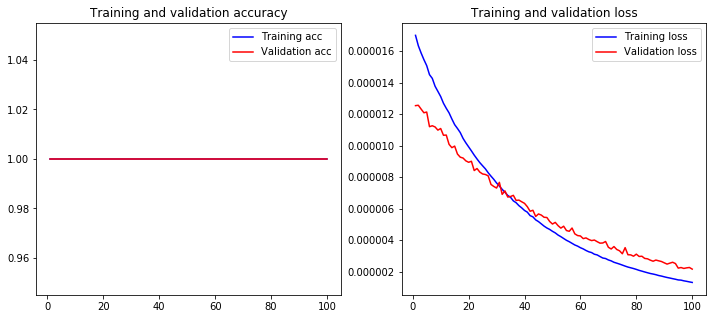

In [102]:
for base_model in br.estimators_['genre_black'].base_models:
    model_name = type(base_model).__name__
    if model_name == 'Sequential':
        plot_history(base_model.history)
        plt.show()
    elif model_name == 'RandomForestClassifier':
        feature_importances = base_model.feature_importances_
        sort_idx = feature_importances.argsort()[:-10:-1]
        plt.bar(np.array(feature_cols)[sort_idx], feature_importances[sort_idx])
        plt.xticks(rotation=45, ha='right')
        plt.title('feature importances')
        plt.show()

# Evaluation plots
### Confusion matrix

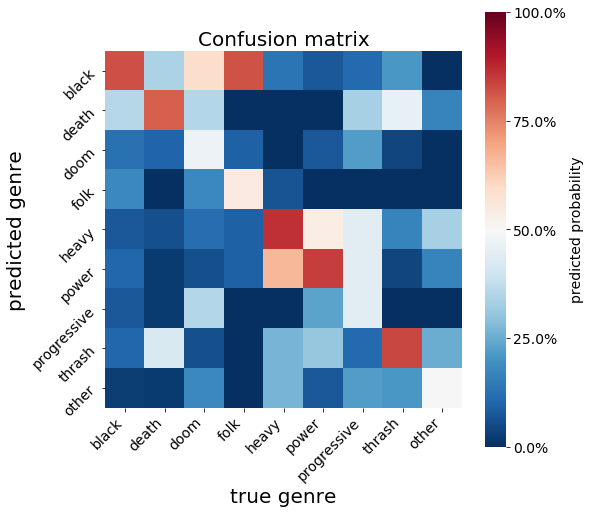

In [10]:
df_confusion = pd.DataFrame(index=label_cols, columns=label_cols)
for label in label_cols:
    col_data = df_pred[df_true[label].astype(bool)].mean(axis=0).sort_values()
    df_confusion[label] = col_data
df_confusion *= 100

plt.figure(figsize=(8, 8))
dz = max(50 - df_confusion.min().min(), df_confusion.max().max() - 50)
zticks = np.linspace(50 - dz, 50 + dz, 5)
ax = sns.heatmap(df_confusion, square=True, cmap='RdBu_r', center=50, vmin=zticks.min(), vmax=zticks.max())
cbar = ax.collections[0].colorbar
cbar.set_label('predicted probability', size=14)
cbar.set_ticks(zticks)
cbar.set_ticklabels(['{}%'.format(x) for x in zticks])
cbar.ax.tick_params(labelsize=14)
plt.title('Confusion matrix', size=20)
plt.xlabel('true genre', size=20)
plt.ylabel('predicted genre', size=20)
plt.tick_params(labelsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')
ax = plt.gca()
ax.xaxis.set_ticklabels(genres)
ax.yaxis.set_ticklabels(genres)
plt.show()

### True labels vs prediction probabilities

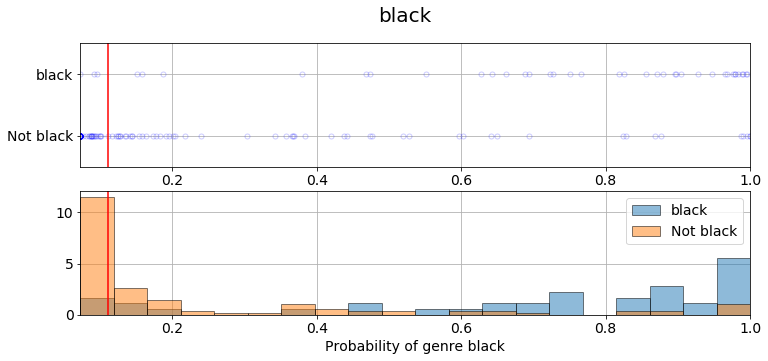

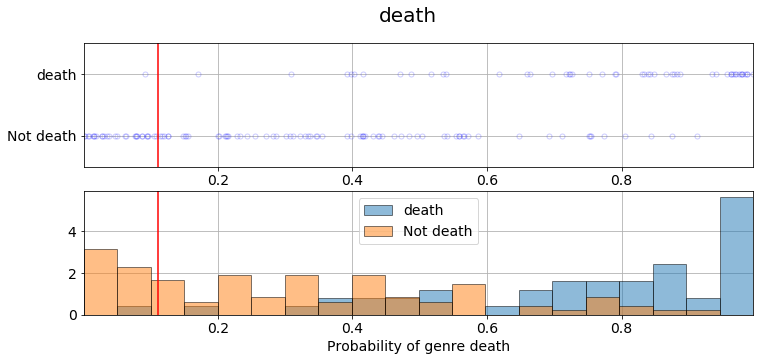

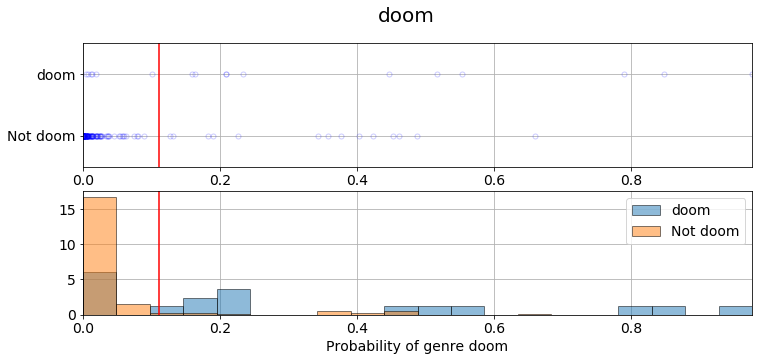

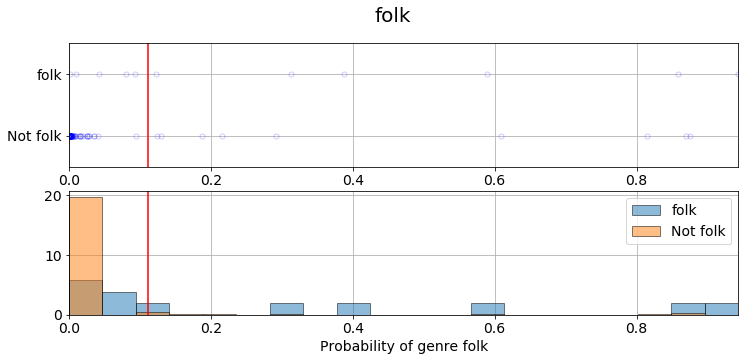

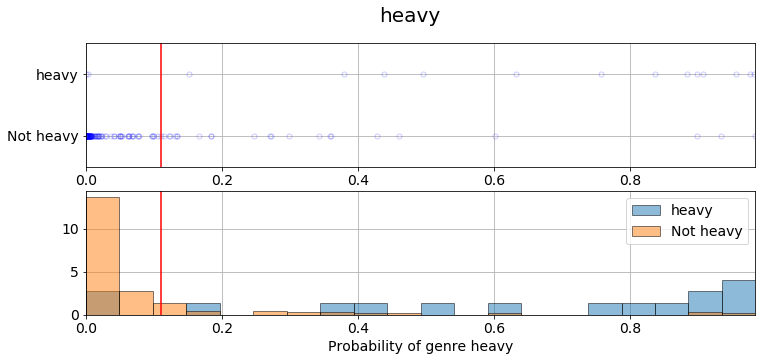

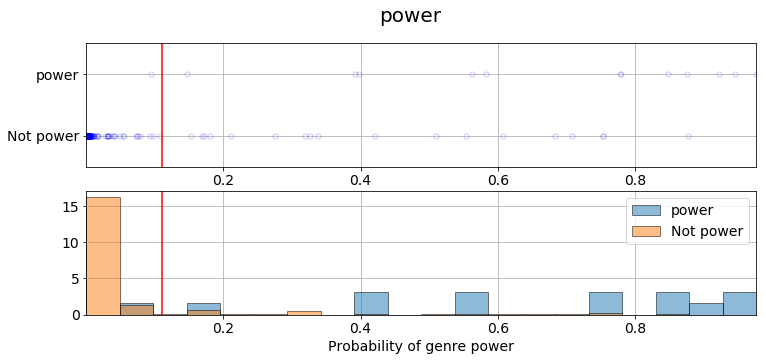

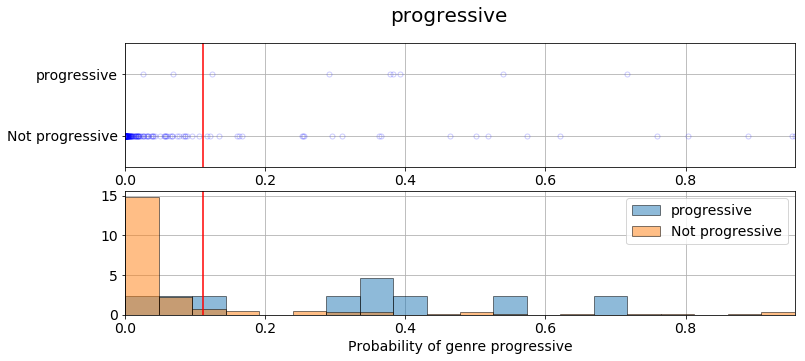

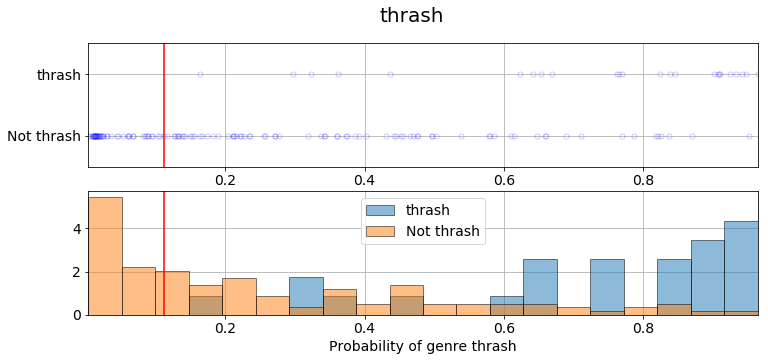

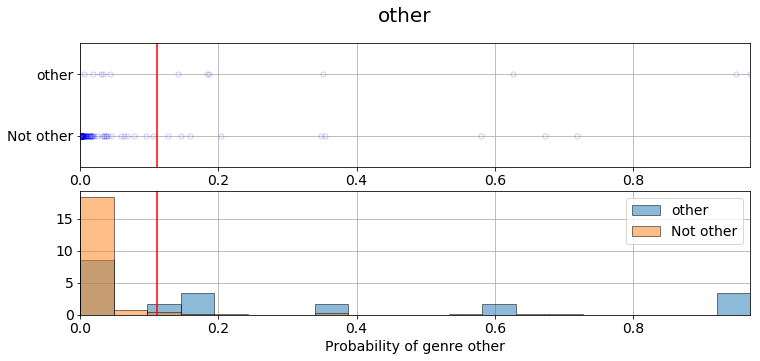

In [138]:
for label in df_pred.columns:
    genre = label.replace('genre_', '')
    y_prob = df_prob[label]
    y_true = df_true[label]
    plt.figure(figsize=(12, 5))
    plt.suptitle(genre, fontsize=20)
    plt.subplot(2, 1, 1)
    plt.plot(y_prob, y_true, 'o', markersize=5, markerfacecolor='none', markeredgecolor='b', alpha=0.2)
    plt.axvline(1 / len(df_pred.columns), color='r')
    plt.xlim(y_prob.min(), y_prob.max())
    plt.ylim(-0.5, 1.5)
    plt.tick_params(labelsize=14)
    plt.yticks([0, 1], ["Not " + genre, genre])
    plt.grid()
    plt.subplot(2, 1, 2)
    bins = np.linspace(y_prob.min(), y_prob.max(), 21)
    plt.hist(y_prob[y_true == 1], bins=bins, alpha=0.5, edgecolor='k', label=genre, density=True)
    plt.hist(y_prob[y_true == 0], bins=bins, alpha=0.5, edgecolor='k', label='Not ' + genre, density=True)
    plt.axvline(1 / len(df_pred.columns), color='r')
    plt.xlim(y_prob.min(), y_prob.max())
    plt.tick_params(labelsize=14)
    plt.xlabel("Probability of genre " + genre, fontsize=14)
    plt.grid()
    plt.gca().set_axisbelow(True)
    plt.legend(fontsize=14)
    plt.show()

### Prediction probabilities of all labels for each true label

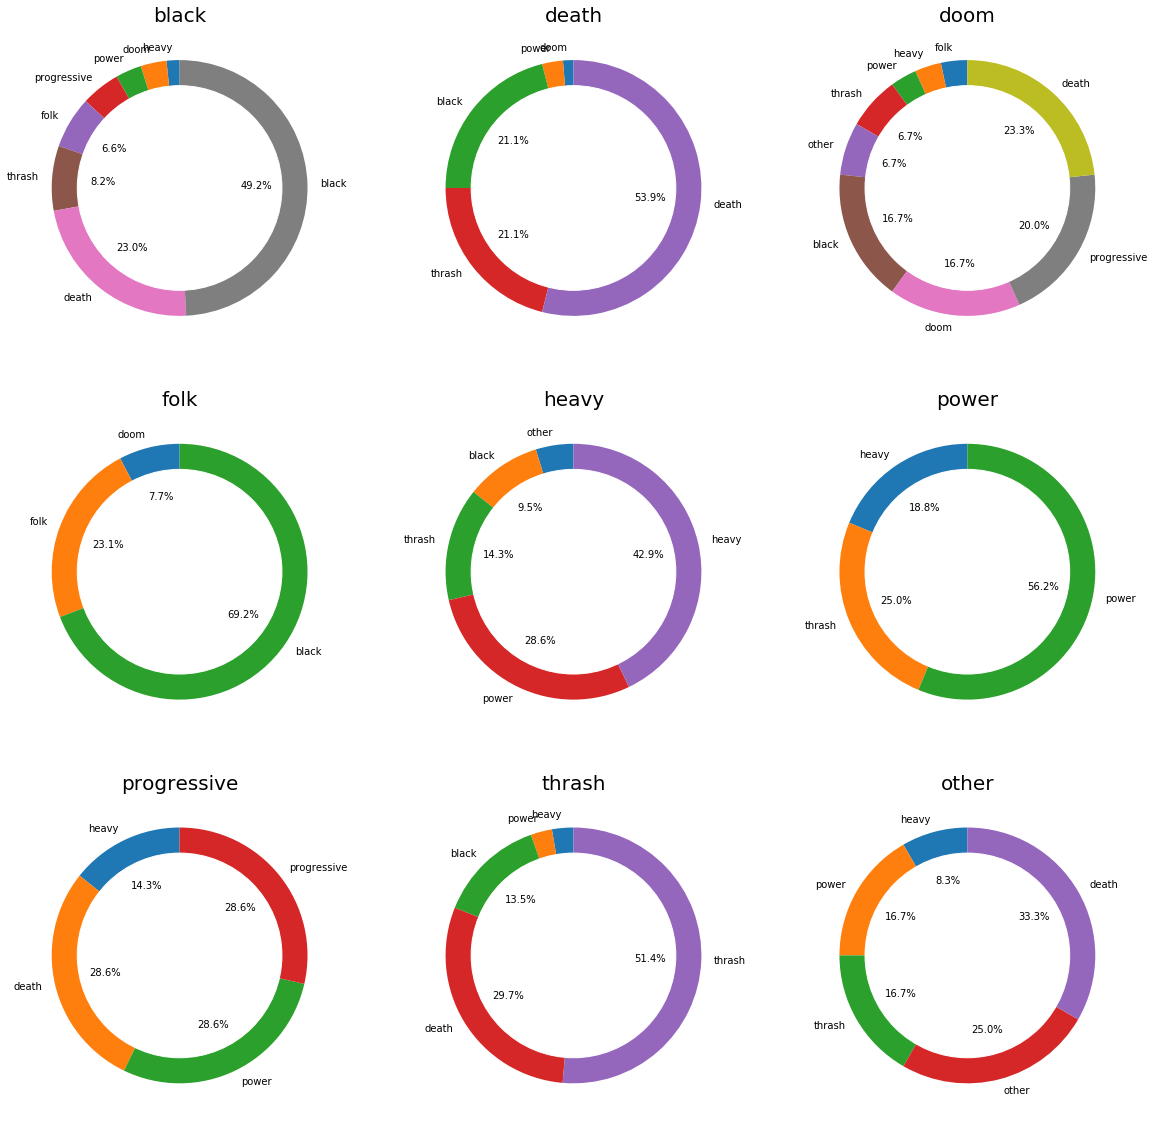

In [139]:
fig, ax = plt.subplots(3, np.ceil(len(label_cols) / 3).astype(int), figsize=(20, 20))
def autopct(pct):
    return ('{:.1f}%'.format(pct) if pct > 5 else '')
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        label = label_cols[i * ax.shape[1] + j]
        pie_data = df_pred[df_true[label].astype(bool)].sum(axis=0).sort_values()
        pie_data = pie_data[pie_data > 0]
        labels = [n.replace('genre_', '') if v > 0.05 else '' for n, v in pie_data.items()]
        ax[i, j].pie(pie_data.values, labels=labels, autopct=autopct, startangle=90)
        ax[i, j].add_artist(plt.Circle((0,0), 0.8, color='white'))
        ax[i, j].set_title(label.replace('genre_', ''), size=20)
plt.show()

### Genre correlations in predictions and true labels

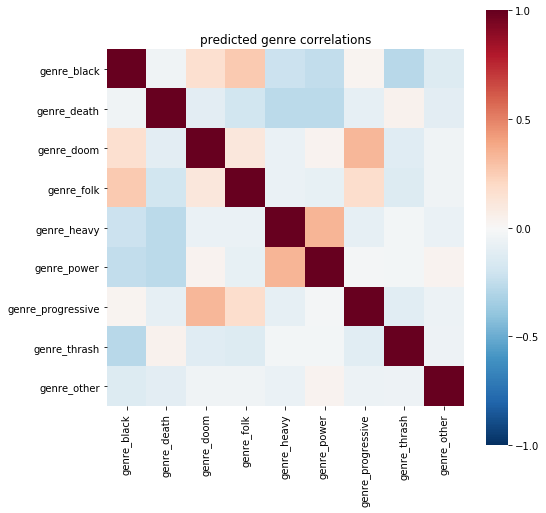

In [140]:
plt.figure(figsize=(8, 8))
ax = sns.heatmap(df_pred.corr(), square=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1)
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.linspace(-1, 1, 5))
plt.title('predicted genre correlations')
plt.show()

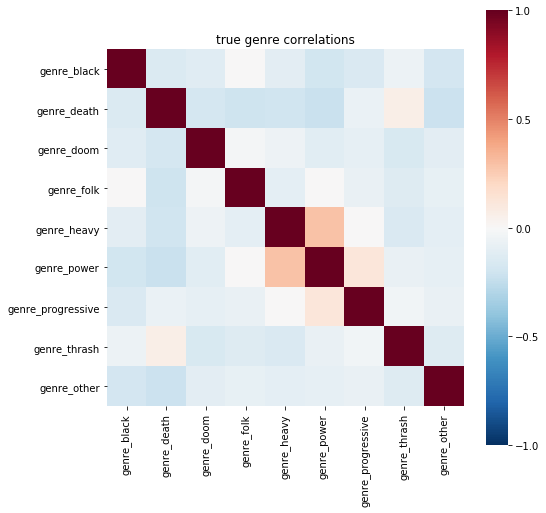

In [141]:
plt.figure(figsize=(8, 8))
ax = sns.heatmap(df_true.corr(), square=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1)
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.linspace(-1, 1, 5))
plt.title('true genre correlations')
plt.show()

### Test your own lyrics

In [107]:
# import pickle as pkl

# vectorizer = pkl.load(open('vectorizer.pkl', 'rb'))
# example = [
#     input('enter some song lyrics: ')
# ]
# example_df = pd.DataFrame(vectorizer.transform(example).toarray(), columns=vectorizer.vocabulary)
# example_pred, example_prob = br.predict(example_df)
# bar_data = example_prob.loc[0].sort_values()
# bar_data.plot(kind='barh')
# plt.grid(axis='x', alpha=0.5)
# ax.set_title('genre prediction probabilities')
# ax.set_yticklabels([n.replace('genre_', '') + ' ({:.1f}%)'.format(100 * v) for n, v in bar_data.items()])
# plt.show()